In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import seaborn as sns

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=200, n_features=2,
                           n_informative=2, n_redundant=0,
                           random_state=42)

data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                    columns=['x1', 'x2', 'y'])

__Задание 1.__

Обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделяющую поверхность на трейне (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились? (2б)

In [3]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

print(f'Train accuracy {tree_model.score(X_train, y_train):.3}')
print(f'Test accuracy {tree_model.score(X_test, y_test):.3}')

Train accuracy 1.0
Test accuracy 0.8


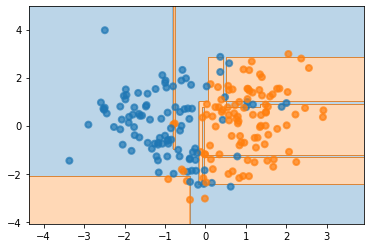

In [6]:
plot_surface(tree_model, X, y)

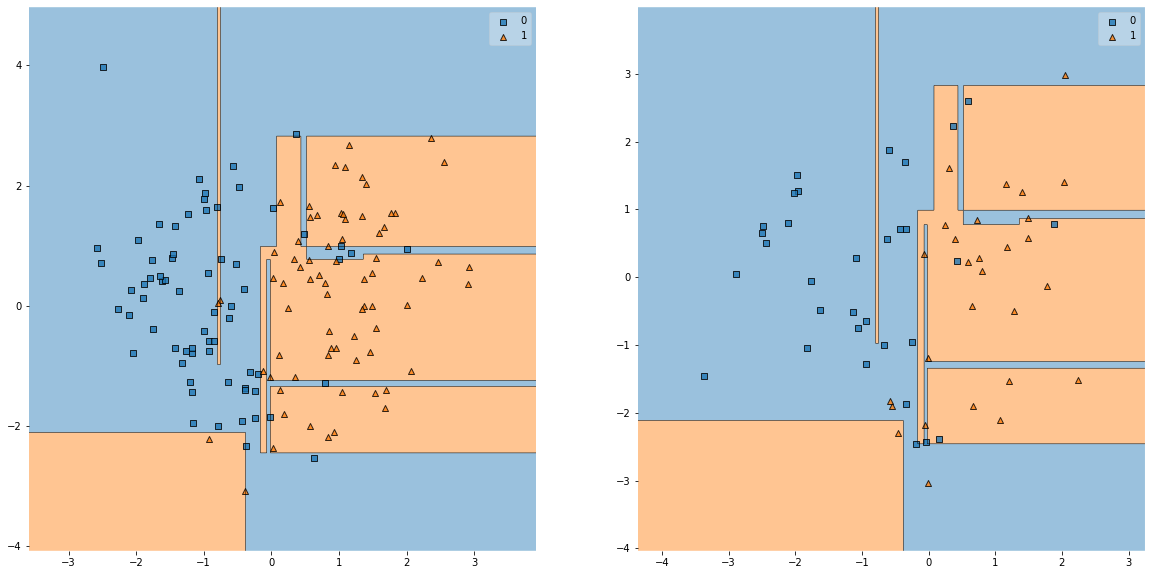

In [7]:
# Аналогичное построение через библиотеку mlxtend

from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 2, 1)
plot_decision_regions(X_train, y_train, tree_model)

ax2 = fig.add_subplot(1, 2, 2)
plot_decision_regions(X_test, y_test, tree_model)

plt.show()

__Задание 2.__

Переберите несколько параметров для регуляризации (`max_depth`, `min_samples_leaf`) из предложенных. Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Используйте, если хотите, функцию ниже. Как изменение параметров влияет на поверхность? При каких параметрах на тесте достигается лучшее качество? А на трейне? (2б).

In [8]:
def plot_surface_axes(clf, X, y, ax, train_acc, test_acc):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
    edgecolors=np.array(palette)[y], linewidths=2)
    
    ax.plot([], [], label = 'train_acc : %0.5f' % train_acc)
    ax.plot([], [], label = 'test_acc : %0.5f' % test_acc)
    
    ax.legend(loc = 'lower right', prop={'size': 20})

In [9]:
max_depth_set = [6, 7, 8, 9, 12]

min_samples_leaf_set = [3, 5, 7, 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 42) 

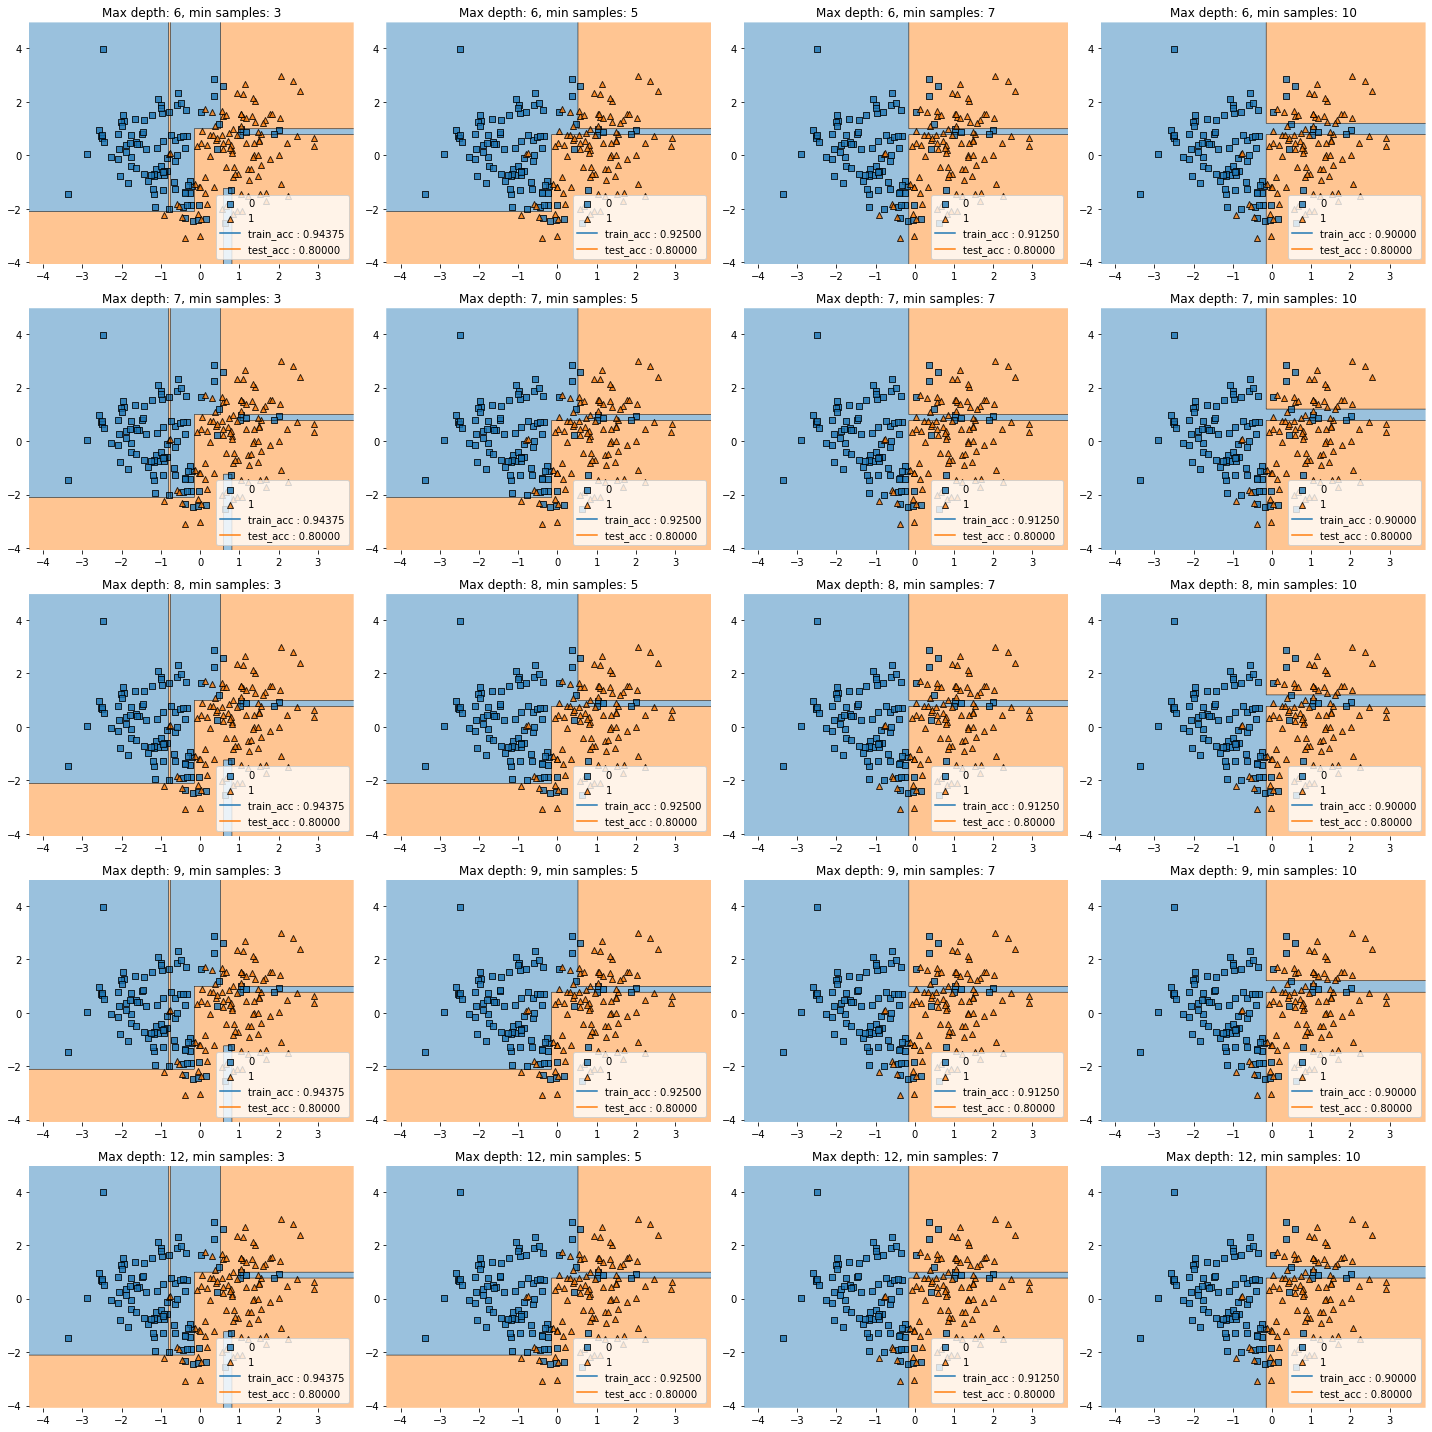

In [10]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))

for i, depth in enumerate(max_depth_set):
    for j, samples in enumerate(min_samples_leaf_set):
        model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples)
        model.fit(X_train, y_train)
        ax[i][j].set_title(f'Max depth: {depth}, min samples: {samples}')
        plot_decision_regions(X, y, model, ax=ax[i][j])
        ax[i][j].plot([], [], label='train_acc : %0.5f' % model.score(X_train, y_train))
        ax[i][j].plot([], [], label='test_acc : %0.5f' % model.score(X_test, y_test))
        ax[i][j].legend(loc='lower right', prop={'size': 10})

plt.tight_layout()
plt.show()

__Задание 3.__

Добавим признак $2\cdot x_1 - x_2$, транформацию добавим как шаг пайплайна. С помощью данного класса (из практики/лекции) обучите дерево с максимальной глубиной=3, нарисуйте поверхность на трейне, посчитайте accuracy (2 б)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, first_col, second_col, function):
        self.first_col = first_col
        self.second_col = second_col
        self.function = function
        # print("Инициализировали класс!")
        
    def fit(self, X, y=None):
        # print("Зафитили датасет!")
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        X_ = pd.DataFrame(X_, columns=['x1', 'x2'])
        X_['new_feature'] = self.function(X_[self.first_col], X_[self.second_col])
        X_ = X_.drop([self.first_col, self.second_col], axis=1)
        
        # print("Трансформировали датасет!")
        return X_

In [12]:
X_train = pd.DataFrame(X_train, columns=['x1', 'x2'])
X_test = pd.DataFrame(X_test, columns=['x1', 'x2'])

In [13]:
from sklearn.pipeline import Pipeline

clf_model = DecisionTreeClassifier(max_depth=3)

pipe = Pipeline([('transformation', CustomFunctionTransformer('x1', 'x2', lambda x1, x2: 2 * x1 - x2)),
                 ('clf', DecisionTreeClassifier(max_depth=3))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 CustomFunctionTransformer(first_col='x1',
                                           function=<function <lambda> at 0x14639e940>,
                                           second_col='x2')),
                ('clf', DecisionTreeClassifier(max_depth=3))])

In [14]:
print(f'Train accuracy: {pipe.score(X_train, y_train):.2}')
print(f'Test accuracy: {pipe.score(X_test, y_test):.2}')

Train accuracy: 0.86
Test accuracy: 0.75


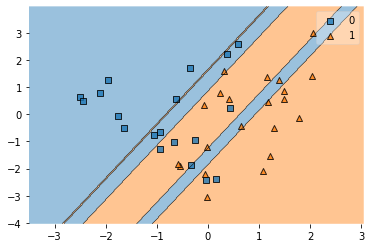

In [15]:
plot_decision_regions(X_test.values, y_test, pipe)
plt.show()